# Diabetic patients readmission rates preditction


In [126]:
!pip install tqdm
!pip install learn2learn
!pip install tensorflow


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [127]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

from learn2learn.algorithms.maml import MAML
from learn2learn.data import TaskDataset

from tqdm import tqdm

# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [128]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
mapping_info = pd.read_csv("Dataset/IDS_mapping.csv", header=None)
pd.set_option('display.max_columns', None)

In [129]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)



In [130]:
# fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 65))
# fig.tight_layout(pad=5.0)


# for i, col in enumerate(train_data.columns):

#     plot_column(axes[i//4, i%4], col,train_data)


# plt.show()

# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [131]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step

# df = train_data.copy()

# df.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
# 'glimepiride-pioglitazone'],inplace=True)
# df.replace('?', np.nan, inplace=True)

# df_test = test_data.copy()
# df_test.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
# 'glimepiride-pioglitazone'],inplace=True)
# df_test.replace('?', np.nan, inplace=True)
df = train_data.copy()
df_test = test_data.copy()

One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories

Race Process
1. Remove missing since race is proved to be a significant impact to medical result.
2. One-hot encode race

In [132]:
def race_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    race_mask = (df['race'] != "?")
    df = df[race_mask]
    return df

In [133]:
df = race_filter(df)
df_encoded = pd.get_dummies(df, columns=["race"], prefix="race",dtype=int)

df_test = race_filter(df_test)
df_test_encoded = pd.get_dummies(df_test, columns=["race"], prefix="race",dtype=int)

Gender Process

1. Remove Unknown/Invalid and missing
2. One hot encode Gender

In [134]:
def gender_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    gender_mask = (df['gender'] != "Unknown/Invalid")
    df = df[gender_mask]
    return df

In [135]:
df_encoded = gender_filter(df_encoded)
df_test_encoded = gender_filter(df_test_encoded)
gender_mapping = {'Male':0,'Female':1}
df_encoded['gender'] = df_encoded['gender'].map(gender_mapping)
df_test_encoded['gender'] = df_test_encoded['gender'].map(gender_mapping)

encounter_id and patient_nbr Process 
1. n/a
2. Drop since it provide no info to the result

In [136]:
df_encoded.drop(columns=['encounter_id','patient_nbr'], inplace=True)
df_test_encoded.drop(columns=['encounter_id','patient_nbr'],inplace=True)

Age Process
1. n/a
2. Map age from range to mean

In [137]:
df_encoded['age'] = (df['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2
df_test_encoded['age'] = (df_test['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df_test['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2

Weight Process
1. Drop Weight for too many missing values and no information to predict.
2. n/a

In [138]:
df_encoded.drop(columns=['weight'], inplace=True)
df_test_encoded.drop(columns=['weight'], inplace=True)

num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient No need to be encode since no missing and integer.

diag_1,diag_2 and diag_3 Process:

Filte diag_1, diag_2 and diag_3 by number_diagnoses. If the amount of diagnoses in diag_1, diag_2 and diag_3 doesn't match the number_diagnoses, then remove.
Layer encoding diags according to the ICD-9 Code Category, drop original 3 diag

In [139]:
def diag_missing_value_filter(df):

    df['number_diagnoses'] = pd.to_numeric(df['number_diagnoses'], errors='coerce')
    mask = ((df['number_diagnoses'] <= 3) & (
            (3 - df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) >= df['number_diagnoses'])) | (
    (df['number_diagnoses'] > 3) & (df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) == 0) 
    df_filtered = df[mask].copy()

    return df_filtered

def diag_layer_encoding(df):

    # Define the encoding function
    def encode_element(element):
        encoding_result = [0] * 20  # Default encoding

        if pd.notna(element):
            if element[0].isdigit():
                element = float(element)
                # Encode based on numeric range
                if 1 <= element <= 139:
                    encoding_result[0] = 1
                elif 140 <= element <= 239:
                    encoding_result[1] = 1
                elif 240 <= element <= 279:
                    encoding_result[2] = 1
                elif 280 <= element <= 289:
                    encoding_result[3] = 1
                elif 290 <= element <= 319:
                    encoding_result[4] = 1
                elif 320 <= element <= 389:
                    encoding_result[5] = 1
                elif 390 <= element <= 459:
                    encoding_result[6] = 1
                elif 460 <= element <= 519:
                    encoding_result[7] = 1
                elif 520 <= element <= 579:
                    encoding_result[8] = 1
                elif 580 <= element <= 629:
                    encoding_result[9] = 1
                elif 630 <= element <= 679:
                    encoding_result[10] = 1
                elif 680 <= element <= 709:
                    encoding_result[11] = 1
                elif 710 <= element <= 739:
                    encoding_result[12] = 1
                elif 740 <= element <= 759:
                    encoding_result[13] = 1
                elif 760 <= element <= 779:
                    encoding_result[14] = 1
                elif 780 <= element <= 799:
                    encoding_result[15] = 1
                elif 800 <= element <= 999:
                    encoding_result[16] = 1
                # Add more conditions for other ranges if needed
            elif element[0].isalpha():
                # Encode based on string prefix
                if element.startswith('E'):
                    encoding_result[17] = 1
                elif element.startswith('V'):
                    encoding_result[18] = 1
                elif element.startswith('M'):
                    encoding_result[19] = 1
                # Add more conditions for other prefixes if needed

        return encoding_result

    for i in range(1,4):
        encoded_columns = df["diag_"+str(i)].apply(encode_element)

    # Create new columns with "diag_1" as a prefix
        for j in range(20):
            new_column_name = "diag_" + str(i)+"_"+ str(j+1)
            df[new_column_name] = encoded_columns.apply(lambda x: x[j])

    return df


In [140]:
df_encoded = diag_missing_value_filter(df_encoded)
df_encoded = diag_layer_encoding(df_encoded)
df_test_encoded = diag_missing_value_filter(df_test_encoded)
df_test_encoded = diag_layer_encoding(df_test_encoded)

for i in range(1,4):
        df_encoded.drop(columns=[f'diag_{i}'], inplace=True)
        df_test_encoded.drop(columns=[f'diag_{i}'], inplace=True)

number_diagnoses pass since no missing and integer max_glu_serum and A1Cresult Process: 
1. n/a 
2. index map to 0-3



In [141]:
max_glu_serum_mapping = {'>200': 2, '>300': 3, 'normal': 1}
A1Cresult_mapping = {'>8':3,'>7':2,'normal':1}

In [142]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)
df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)

df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)
df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)

metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone Process:

1. drop 'examide', 'citoglipton','glimepiride-pioglitazone' and 'metformin-rosiglitazone' since single value observed
2. index map to 0-3

In [143]:
df_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
df_test_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'metformin-pioglitazone']
for i in medics:
    df_encoded.loc[df_encoded[i] == 'Up', [i]] = 3  
    df_encoded.loc[df_encoded[i] == 'Down', [i]] = 1 
    df_encoded.loc[df_encoded[i] == 'Steady', [i]] = 2 
    df_encoded.loc[df_encoded[i] == 'No', [i]] = 0
    df_test_encoded.loc[df_test_encoded[i] == 'Up', [i]] = 3  
    df_test_encoded.loc[df_test_encoded[i] == 'Down', [i]] = 1 
    df_test_encoded.loc[df_test_encoded[i] == 'Steady', [i]] = 2 
    df_test_encoded.loc[df_test_encoded[i] == 'No', [i]] = 0 
 

change and diabetesMed Process

1. n/a
2. binary map to 1/0

In [144]:
change_mapping = {'No':0,'Ch':1}
diabetesMed_mapping = {'No':0,'Yes':1}

df_encoded['change'] = df_encoded['change'].map(change_mapping)
df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map(diabetesMed_mapping)

df_test_encoded['change'] = df_test_encoded['change'].map(change_mapping)
df_test_encoded['diabetesMed'] = df_test_encoded['diabetesMed'].map(diabetesMed_mapping)

readmitted Process: 
1. n/a 
2. index mapping, No as 0, >30 as 1 and <30 as most significant as 2 and drop readmitted for test

In [145]:
readmitted_mapping = {'NO':0,'<30':2,'>30':1}
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)
df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

y_test_readmitted = df_encoded["readmitted"]
y_readmitted = df_test_encoded["readmitted"]

df_encoded.drop(columns=["readmitted"],axis=1,inplace=True)
df_test_encoded.drop(columns=["readmitted"],axis=1,inplace=True)

'admission_type_id','discharge_disposition_id','admission_source_id' Process:
1. n/a
2. target encoding

In [146]:
X_train = df_encoded
Y_train = y_test_readmitted

features = ['admission_type_id','discharge_disposition_id','admission_source_id']

'''for name in names:
    category_means = df_encoded.groupby(name)['readmitted'].mean().reset_index()
    category_means.columns = [name,name+'_readmitted_Mean']
    df_encoded = pd.merge(df_encoded, category_means, on=name, how='left')
    df_encoded = df_encoded.drop(name, axis=1)'''


for feature in features:
    
    mean_col_name = f'{feature}_Encoded'
    means = X_train.join(Y_train).groupby(feature)['readmitted'].mean()
    df_encoded[mean_col_name] = df_encoded[feature].map(means)
    df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)

    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)

Payer Code and medical_specialty Process:
1.1 index encoding payer code
1.2 RandomForestClassifier fill missing


1.3 KNN filling missing

2. target encoding

In [147]:
def payer_code_index_encoding(df):
    df.loc[df['payer_code'] == 'MD', ['payer_code']] = 1
    df.loc[df['payer_code'] == 'MC', ['payer_code']] = 2
    df.loc[df['payer_code'] == 'HM', ['payer_code']] = 3
    df.loc[df['payer_code'] == 'UN', ['payer_code']] = 4
    df.loc[df['payer_code'] == 'BC', ['payer_code']] = 5
    df.loc[df['payer_code'] == 'CP', ['payer_code']] = 6
    df.loc[df['payer_code'] == 'SP', ['payer_code']] = 7
    df.loc[df['payer_code'] == 'SI', ['payer_code']] = 8
    df.loc[df['payer_code'] == 'CM', ['payer_code']] = 9
    df.loc[df['payer_code'] == 'DM', ['payer_code']] = 10
    df.loc[df['payer_code'] == 'CH', ['payer_code']] = 11
    df.loc[df['payer_code'] == 'PO', ['payer_code']] = 12
    df.loc[df['payer_code'] == 'WC', ['payer_code']] = 13
    df.loc[df['payer_code'] == 'OG', ['payer_code']] = 14
    df.loc[df['payer_code'] == 'OT', ['payer_code']] = 15
    df.loc[df['payer_code'] == 'MP', ['payer_code']] = 16
    df.loc[df['payer_code'] == 'FR', ['payer_code']] = 17
    return df

In [148]:
df_encoded = payer_code_index_encoding(df_encoded)
df_test_encoded = payer_code_index_encoding(df_test_encoded)

In [149]:
#separating the columns that contain null values and need to predicted.
payer_code_col = ['payer_code']
medical_specialty_cols = ['medical_specialty']
other_cols = list(df_encoded.columns)
other_cols.remove("payer_code")
other_cols.remove("medical_specialty")

Random Forst

In [153]:
payer_code_mask = (df_encoded["payer_code"] != "?")
df_notnans = df_encoded[payer_code_mask]

X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans[payer_code_col].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)

rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X_test, y_test.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   6.9s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   6.9s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   7.0s
[CV] END max_depth=100

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [25, 30, 50, 100],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400]},
                   random_state=1, verbose=2)

In [154]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 100}

In [155]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5634790392361629


KNN filling

In [158]:
train_score = []
test_score = []

for i in range(6,30,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.values.ravel())
    
    train_score.append(knn.score(X_train,y_train.values.ravel()))
    test_score.append(knn.score(X_test,y_test.values.ravel()))

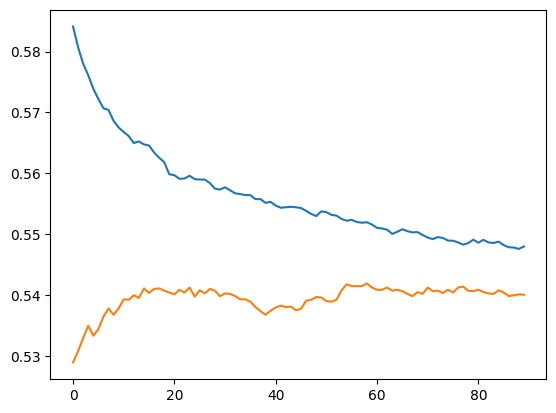

In [166]:
plt.plot(train_score)
plt.plot(test_score)

In [168]:
knn2 =(KNeighborsClassifier(n_neighbors= 21))
# # Fit on the train data
knn2.fit(X_train, y_train.values.ravel())

# # Check the prediction score
score = knn2.score(X_test, y_test.values.ravel())
print(f"Thescore on the testset is {score}")

Thescore on the testset is 0.539236162912129


In [ ]:
# this part will recognise the ?, the missing value in training data
# When we have recognised it, we will use **** method to full up it
# the method we can discuss: 
#   delete
#   mean,median or mode
#   knn to predict
#   Multiple Imputation

In [49]:

# predict_nan = df_encoded.copy()


# df_real_ms_index = predict_nan.index[predict_nan['medical_specialty'] != 0]
# unique_rows_index = predict_nan.index[predict_nan['medical_specialty'].duplicated(keep=False)]
# df_real_ms_index_total = df_real_ms_index.join(unique_rows_index,how = 'inner')

# df_real_pc_index = predict_nan.index[predict_nan['payer_code'] != 0]
# unique_rows_index = predict_nan.index[predict_nan['payer_code'].duplicated(keep=False)]
# df_real_pc_index_total = df_real_pc_index.join(unique_rows_index,how = 'inner')

# df_real_ms = predict_nan.loc[df_real_ms_index_total,['medical_specialty']]
# df_real_pc = predict_nan.loc[df_real_pc_index_total,['payer_code']]

# predict_nan.drop(columns = ['medical_specialty','payer_code'],inplace = True)

# df_data_train_ms = predict_nan.loc[df_real_ms_index_total]
# df_data_predict_ms = predict_nan.loc[~predict_nan.index.isin(df_real_ms_index)]

# df_data_train_pc = predict_nan.loc[df_real_pc_index_total]
# df_data_predict_pc = predict_nan.loc[~predict_nan.index.isin(df_real_pc_index)]

In [ ]:
# # this part will reduce the dimension our training data

# missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
# missing_value_predict_model.fit(df_data_train_ms,df_real_ms['medical_specialty'])
# df_encoded['medical_specialty'].loc[~df_encoded['medical_specialty'].index.isin(df_real_ms_index)] = missing_value_predict_model.predict(df_data_predict_ms)

# missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
# missing_value_predict_model.fit(df_data_train_pc,df_real_pc)
# df_encoded['payer_code'].loc[~df_encoded['payer_code'].index.isin(df_real_pc_index)] = missing_value_predict_model.predict(df_data_predict_pc)

Dems Redct
1. PCA/PPCA
2. LDA/QDA
3. following to T-SNE
3. Autoencoders
4. Unsupervised Algorithmn

In [198]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Simulating Data
np.random.seed(0)
num_samples = 1000
num_features = 5

# Numerical data
numeric_data = np.random.randn(num_samples, num_features)

# Categorical data (let's say, colors)
colors = ['Red', 'Green', 'Blue']
categorical_data = np.random.choice(colors, size=num_samples)

# Convert categorical data to one-hot encoding
encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(categorical_data.reshape(-1, 1))

# Combining numerical and categorical data
combined_data = np.hstack((numeric_data, categorical_encoded))

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(scaled_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plotting the results
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=categorical_data, palette='bright')
plt.title('t-SNE plot of the dataset')
plt.xlabel('t-SNE Axis 1')


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NameError: name 'sns' is not defined

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_shape = combined_data.shape[1]  # combined data from previous steps
encoding_dim = 32  # example of encoding dimension

# This is our input placeholder
input_data = Input(shape=(input_shape,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_shape, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(combined_data, combined_data, epochs=50, batch_size=256, shuffle=True)


# Model Building
We will build two models: 
1. A traditional machine learning model using Random Forest.
2. A deep learning model using PyTorch.


At the first step we will try to use the Random Forest method to get the result

In [ ]:
# the code for Random Forest algorithm

In [ ]:
# the code for Nerual Network

# Model Training


In [199]:
df_encoded['A1Cresult'].value_counts()

A1Cresult
0.0    76279
3.0     7398
1.0     4479
2.0     3430
Name: count, dtype: int64

In [200]:
(df_normalized.astype(float) < 0).any()

age                                         True
time_in_hospital                            True
payer_code                                  True
medical_specialty                           True
num_lab_procedures                          True
num_procedures                              True
num_medications                             True
number_outpatient                           True
number_emergency                            True
number_inpatient                            True
max_glu_serum                               True
A1Cresult                                   True
metformin                                   True
repaglinide                                 True
nateglinide                                 True
chlorpropamide                              True
glimepiride                                 True
acetohexamide                               True
glipizide                                   True
glyburide                                   True
tolbutamide         

In [205]:
# training loop
# Random Forest
from sklearn.feature_selection import SelectKBest, chi2

# 选择最好的K个特征


Y = df_encoded['readmitted']
#df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = df_encoded.drop('readmitted', axis=1)

selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, Y)


rf_classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
rf_classifier.fit(X, Y)

# Nerual Network

HistGradientBoostingClassifier(random_state=42)

In [202]:

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, Y)

RandomForestClassifier()

# Model Evaluation

In [207]:
# use testing dataset to predict
Y_test = df_test_encoded['readmitted']
#df_test_normalized = pd.DataFrame(scaler.fit_transform(df_test_encoded), columns=df_test_encoded.columns)
X_test = df_test_encoded.drop('readmitted', axis=1)
#X_test = selector.transform(X_test)

Y_pred = rf_classifier.predict(X_test)
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))

[0 0 0 ... 0 0 2]
0        0
1        2
2        0
3        0
4        2
        ..
10172    2
10173    0
10174    0
10175    1
10176    2
Name: readmitted, Length: 10177, dtype: int64
0.5851429694408962


In [208]:
Y_pred = classifier.predict(df_test_encoded.drop('readmitted', axis=1))
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))

[0 0 0 ... 0 0 2]
0        0
1        2
2        0
3        0
4        2
        ..
10172    2
10173    0
10174    0
10175    1
10176    2
Name: readmitted, Length: 10177, dtype: int64
0.5586125577282107
